In [140]:
#Zaimportowanie wymaganych bibliotek
import os
import numpy as np
from pathlib import Path
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU,Conv2DTranspose
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Mean
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn,randint,normal
from IPython.display import clear_output

from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

from PIL import Image

In [141]:
PATH_TO_DATA='Cubism/cubism_data_norm.npy'
#PATH_TO_DATA='data/delaunay_data_norm.npy'
#Parametry
#Preview image Frame
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 4

SAVE_FREQ = 100#How often to save images
'''
In this use case, our latent space representations are used to
transform more complex forms of raw data (i.e. images, video),
into simpler representations which are "more convenient to process" and analyze.
'''
NOISE_SIZE = 128#Lantent dimention size

EPOCHS = 5000 #Iterations 100000
BATCH_SIZE = 32
GENERATE_RES = 2

IMAGE_SIZE = 64 #rows/cols
IMAGE_CHANNELS = 3#colour channels in our images

cross_entropy=BinaryCrossentropy()
mean=Mean()

In [142]:
train_data = np.load(PATH_TO_DATA)
train_data.shape

(2235, 64, 64, 3)

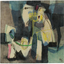

In [143]:
Image.fromarray(((train_data[1]+1)*255/2).astype(np.uint8))

In [145]:
#discriminator
def build_discriminator(image_shape):
    model = Sequential()
        
    #model.add(Conv2D(32, kernel_size=4, strides=2,input_shape=image_shape,data_format="channels_last",padding="same"))
    #model.add(BatchNormalization(axis=1,momentum=0.8))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))#dropout layier to prevent overfitting    
    
    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same",use_bias=False,input_shape=image_shape,data_format="channels_last"))
    #model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.20))    

    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same",use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.20))    
    
    model.add(Conv2D(256, kernel_size=4, strides=2, padding="same",use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dropout(0.20))
    
    model.add(Conv2D(512, kernel_size=4, strides=1, padding="same",use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dropout(0.20))
    
    model.add(Conv2D(1, kernel_size=4, strides=1, padding="valid",use_bias=False))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))#binary clasification

    input_image = Input(shape=image_shape)
    validity = model(input_image)
    
    return Model(input_image, validity)

In [146]:
#generator
def build_generator(noise_size, channels):
     model = Sequential()
     model.add(Dense(1 * 1 * noise_size, activation="relu",input_dim=noise_size))
     model.add(Reshape((1, 1, noise_size)))    
     model.add(Conv2DTranspose(512,kernel_size=4, strides=1, padding="valid", use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))    

               
     #model.add(UpSampling2D())
     #model.add(Conv2D(256, kernel_size=4, padding="same"))
     model.add(Conv2DTranspose(256,kernel_size=4, strides=2, padding="same", use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))    

     #model.add(UpSampling2D())
     #model.add(Conv2D(256, kernel_size=4, padding="same"))
     model.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding="same", use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))
     
     model.add(Conv2DTranspose(64,kernel_size=4, strides=2, padding="same", use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))        

     #for i in range(GENERATE_RES):
     #     model.add(UpSampling2D())
     #     model.add(Conv2D(256, kernel_size=4, padding="same"))
     #     model.add(BatchNormalization(momentum=0.8))
     #     model.add(Activation("relu"))    
          
     model.add(Conv2DTranspose(channels, kernel_size=4,strides=2, padding="same",use_bias=False))
     model.add(Activation("tanh"))    

     model.summary()
     
     input = Input(shape=(noise_size,))
     generated_image = model(input)

     return Model(input, generated_image)

In [147]:
def save_images(cnt, noise,generator):
    image_array = np.full((
        PREVIEW_MARGIN + (PREVIEW_ROWS * (IMAGE_SIZE + PREVIEW_MARGIN)),
        PREVIEW_MARGIN + (PREVIEW_COLS * (IMAGE_SIZE + PREVIEW_MARGIN)), 3),
        255, dtype=np.uint8)
    generated_images = generator.predict(noise)
    generated_images = (generated_images+1)/2#(generated_images+1)/2   0.5*generated_images+1
    
    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (IMAGE_SIZE + PREVIEW_MARGIN) + PREVIEW_MARGIN
            c = col * (IMAGE_SIZE + PREVIEW_MARGIN) + PREVIEW_MARGIN
            image_array[r:r + IMAGE_SIZE, c:c +
                        IMAGE_SIZE] = generated_images[image_count] * 255
            image_count += 1    
    output_path = 'output'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    filename = os.path.join(output_path, f"trained-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [167]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [149]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [150]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save('models/'+filename)

In [153]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    print(dataset.shape[0])
    half_batch = int(n_batch / 2)
    fixed_noise = normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, NOISE_SIZE))
    number=1
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('Epoch:%d, Batch:%d/%d, d_loss=%.3f, g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            
            save_images(number, fixed_noise,g_model)
            number+=1
            clear_output()
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            

In [154]:
image_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
d_model = build_discriminator(image_shape)
opt = Adam(lr=0.0002, beta_1=0.5)
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])    

g_model = build_generator(NOISE_SIZE, IMAGE_CHANNELS)
gan_model = define_gan(g_model, d_model)
print(train_data.shape)
train(g_model, d_model, gan_model, np.array(train_data), NOISE_SIZE,EPOCHS,BATCH_SIZE)
#print(train_data)


4/4 [==============================] - 0s 31ms/step
>Accuracy real: 100%, fake: 100%
1/1 [==============================] - 0s 40ms/step
>761, 1/69, d=0.000, g=0.000
1/1 [==============================] - 0s 43ms/step
>761, 2/69, d=0.000, g=0.375
1/1 [==============================] - 0s 40ms/step
>761, 3/69, d=0.000, g=0.000
1/1 [==============================] - 0s 40ms/step
>761, 4/69, d=0.000, g=0.000
1/1 [==============================] - 0s 37ms/step
>761, 5/69, d=0.000, g=0.000
1/1 [==============================] - 0s 36ms/step
>761, 6/69, d=0.000, g=0.000
1/1 [==============================] - 0s 38ms/step
>761, 7/69, d=0.000, g=0.000
1/1 [==============================] - 0s 38ms/step
>761, 8/69, d=0.002, g=0.000
1/1 [==============================] - 0s 38ms/step
>761, 9/69, d=0.016, g=0.003
1/1 [==============================] - 0s 37ms/step
>761, 10/69, d=0.000, g=0.000
1/1 [==============================] - 0s 38ms/step
>761, 11/69, d=0.000, g=0.000
1/1 [=================

>762, 51/69, d=0.001, g=0.015
1/1 [==============================] - 0s 61ms/step
>762, 52/69, d=0.003, g=0.004
1/1 [==============================] - 0s 50ms/step
>762, 53/69, d=0.003, g=0.000
1/1 [==============================] - 0s 40ms/step
>762, 54/69, d=0.001, g=0.000
1/1 [==============================] - 0s 42ms/step
>762, 55/69, d=0.000, g=0.000
1/1 [==============================] - 0s 43ms/step
>762, 56/69, d=0.001, g=0.000
1/1 [==============================] - 0s 36ms/step
>762, 57/69, d=0.001, g=0.101
1/1 [==============================] - 0s 41ms/step
>762, 58/69, d=0.000, g=0.975
1/1 [==============================] - 0s 41ms/step
>762, 59/69, d=0.000, g=0.000
1/1 [==============================] - 0s 37ms/step
>762, 60/69, d=0.000, g=0.002
1/1 [==============================] - 0s 39ms/step
>762, 61/69, d=0.001, g=0.080
1/1 [==============================] - 0s 38ms/step
>762, 62/69, d=0.000, g=0.000
1/1 [==============================] - 0s 36ms/step
>762, 63/69, d=0

KeyboardInterrupt: 

In [166]:

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
model = g_model
latent_points = generate_latent_points(128,1)
X = model.predict(latent_points)
#array = np.array(((0.5*X.reshape(64,64,3)+1)*255).astype(np.uint8))
array = np.array(((X.reshape(64,64,3)+1)*255/2).astype(np.uint8))

new_image = Image.fromarray(array)
new_image.show()

#X

1/1 [==============================] - 0s 18ms/step
